# Workflow and Agent

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datascienceworld-kan/vinagent-docs/blob/main/docs/tutorials/get_started/workflow_and_agent.ipynb)

In [ ]:
%pip install vinagent

The Vinagent library enables the integration of workflows built upon the nodes and edges of LangGraph. What sets it apart is our major improvement in representing a LangGraph workflow through a more intuitive syntax for connecting nodes using the right shift operator (>>). All agent patterns such as ReAct, chain-of-thought, and reflection can be easily constructed using this simple and readable syntax.

We support two styles of creating a workflow:

- `FlowStateGraph`: Create nodes by concrete class nodes inherited from class Node of vinagent.
- `FunctionStateGraph`: Create a workflow from function, which are decorated with @node to convert this function as a node.


## FlowStateGraph

These are steps to create a workflow:

1. Define General Nodes
Create your workflow nodes by inheriting from the base Node class. Each node typically implements two methods:

- `exec`: Executes the task associated with the node and returns a partial update to the shared state.

- `branching` (optional): For conditional routing. It returns a string key indicating the next node to be executed.

2. Connect Nodes with `>>` Operator
Use the right shift operator (`>>`) to define transitions between nodes. For branching, use a dictionary to map conditions to next nodes.


In [1]:
from typing import Annotated, TypedDict
from vinagent.graph.operator import FlowStateGraph, END, START
from vinagent.graph.node import Node
from langgraph.checkpoint.memory import MemorySaver
from langgraph.utils.runnable import coerce_to_runnable

# Define a reducer for message history
def append_messages(existing: list, update: dict) -> list:
    return existing + [update]

# Define the state schema
class State(TypedDict):
    messages: Annotated[list[dict], append_messages]
    sentiment: str

# Optional config schema
class ConfigSchema(TypedDict):
    user_id: str

# Define node classes
class AnalyzeSentimentNode(Node):
    def exec(self, state: State) -> dict:
        message = state["messages"][-1]["content"]
        sentiment = "negative" if "angry" in message.lower() else "positive"
        return {"sentiment": sentiment}

    def branching(self, state: State) -> str:
        return "human_escalation" if state["sentiment"] == "negative" else "chatbot_response"

class ChatbotResponseNode(Node):
    def exec(self, state: State) -> dict:
        return {"messages": {"role": "bot", "content": "Got it! How can I assist you further?"}}

class HumanEscalationNode(Node):
    def exec(self, state: State) -> dict:
        return {"messages": {"role": "bot", "content": "I'm escalating this to a human agent."}}

# Define the Agent with graph and flow
class Agent:
    def __init__(self):
        self.checkpoint = MemorySaver()
        self.graph = FlowStateGraph(State, config_schema=ConfigSchema)
        self.analyze_sentiment_node = AnalyzeSentimentNode()
        self.human_escalation_node = HumanEscalationNode()
        self.chatbot_response_node = ChatbotResponseNode()

        self.flow = [
            self.analyze_sentiment_node >> {
                "chatbot_response": self.chatbot_response_node,
                "human_escalation": self.human_escalation_node
            },
            self.human_escalation_node >> END,
            self.chatbot_response_node >> END
        ]

        self.compiled_graph = self.graph.compile(checkpointer=self.checkpoint, flow=self.flow)

    def invoke(self, input_state: dict, config: dict) -> dict:
        return self.compiled_graph.invoke(input_state, config)

# Test the agent
agent = Agent()
input_state = {
    "messages": {"role": "user", "content": "I'm really angry about this!"}
}
config = {"configurable": {"user_id": "123"}, "thread_id": "123"}
result = agent.invoke(input_state, config)
print(result)

{'messages': [{'role': 'user', 'content': "I'm really angry about this!"}, {'role': 'bot', 'content': "I'm escalating this to a human agent."}], 'sentiment': 'negative'}


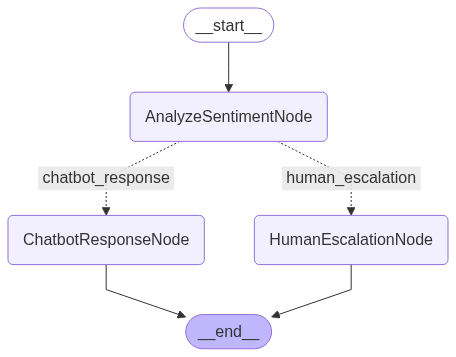

In [2]:
agent.compiled_graph

## FunctionStateGraph

We can simplify the coding style of a graph by converting each function into a node and assigning it a name.

1. Each node will be a function with the same name as the node itself. However, you can override this default by using the `@node(name="your_node_name")` decorator.

2. If your node is a conditionally branching node, you can use the `@node(branching=fn_branching)` decorator, where `fn_branching` is a function that determines the next node(s) based on the return value of current state of node.

3. In the Agent class constructor, we define a flow as a list of routes that connect these node functions.

In [3]:
from typing import Annotated, TypedDict
from vinagent.graph.operator import END, START
from vinagent.graph.function_graph import node, FunctionStateGraph
from vinagent.graph.node import Node
from langgraph.checkpoint.memory import MemorySaver
from langgraph.utils.runnable import coerce_to_runnable

# Define a reducer for message history
def append_messages(existing: list, update: dict) -> list:
    return existing + [update]

# Define the state schema
class State(TypedDict):
    messages: Annotated[list[dict], append_messages]
    sentiment: str

# Optional config schema
class ConfigSchema(TypedDict):
    user_id: str

def branching(state: State) -> str:
    return "human_escalation" if state["sentiment"] == "negative" else "chatbot_response"

@node(branching=branching, name='AnalyzeSentiment')
def analyze_sentiment_node(state: State) -> dict:
    message = state["messages"][-1]["content"]
    sentiment = "negative" if "angry" in message.lower() else "positive"
    return {"sentiment": sentiment}

@node(name='ChatbotResponse')
def chatbot_response_node(state: State) -> dict:
    return {"messages": {"role": "bot", "content": "Got it! How can I assist you further?"}}

@node(name='HumanEscalation')
def human_escalation_node(state: State) -> dict:
    return {"messages": {"role": "bot", "content": "I'm escalating this to a human agent."}}

# Define the Agent with graph and flow
class Agent:
    def __init__(self):
        self.checkpoint = MemorySaver()
        self.graph = FunctionStateGraph(State, config_schema=ConfigSchema)

        self.flow = [
            analyze_sentiment_node >> {
                "chatbot_response": chatbot_response_node,
                "human_escalation": human_escalation_node
            },
            human_escalation_node >> END,
            chatbot_response_node >> END
        ]

        self.compiled_graph = self.graph.compile(checkpointer=self.checkpoint, flow=self.flow)

    def invoke(self, input_state: dict, config: dict) -> dict:
        return self.compiled_graph.invoke(input_state, config)

# Test the agent
agent = Agent()
input_state = {
    "messages": {"role": "user", "content": "I'm really angry about this!"}
}
config = {"configurable": {"user_id": "123"}, "thread_id": "123"}
result = agent.invoke(input_state, config)
print(result)

{'messages': [{'role': 'user', 'content': "I'm really angry about this!"}, {'role': 'bot', 'content': "I'm escalating this to a human agent."}], 'sentiment': 'negative'}


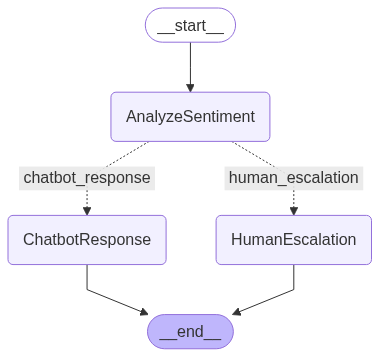

In [ ]:
agent.compiled_graph